In [19]:
# !sudo add-apt-repository -y universe 
# !apt install -y freeglut3-dev
# !apt-get -y install xvfb
# !pip install pyvirtualdisplay miniworld gymnasium matplotlib tqdm

In [20]:
# from pyvirtualdisplay import Display

# display = Display(visible=0, size=(800, 600))
# display.start()

# import os
# # Make sure we are NOT forcing pyglet headless; clear any leftovers
# os.environ.pop("PYGLET_HEADLESS", None)
# os.environ.pop("MINIWORLD_HEADLESS", None)

In [21]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict, deque, OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import miniworld
from tqdm import tqdm
import random
from PIL import Image
import sys
import os

# Set device - M4 Mac should use MPS!
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: CUDA")
else:
    device = torch.device('cpu')
    print(f"Using device: CPU (SLOW!)")

print(f"Device: {device}")

Using device: MPS (Apple Silicon GPU)
Device: mps


In [22]:

class Encoder(nn.Module):
    """
    3.1 Encoder: CNN + MLP
    Input: o_t ∈ R^(3×64×64)
    Output: e_t ∈ R^(d_e) (e.g., 128)
    """
    def __init__(self, embedding_dim=128):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        
        # CNN: 4 conv layers, stride 2
        # Channels: 32 → 64 → 128 → 256
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # After 4 stride-2 convolutions: 64 → 32 → 16 → 8 → 4
        # So spatial size is 4x4
        self.flatten_dim = 256 * 4 * 4
        
        # MLP: 1024 → embedding_dim
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, embedding_dim),
        )
    
    def forward(self, obs):
        """
        Args:
            obs: (B, 3, 64, 64) tensor
        Returns:
            e_t: (B, embedding_dim) tensor
        """
        x = self.cnn(obs)
        e_t = self.mlp(x)
        return e_t


class RSSM(nn.Module):
    """
    3.2 RSSM latent dynamics
    Maintains deterministic state h_t and stochastic state z_t
    """
    def __init__(self, action_dim, embedding_dim=128, hidden_dim=200, stochastic_dim=64):
        super(RSSM, self).__init__()
        self.hidden_dim = hidden_dim
        self.stochastic_dim = stochastic_dim
        self.action_dim = action_dim
        self.embedding_dim = embedding_dim
        
        # Prior network (prediction)
        # Input: [z_{t-1}, a_{t-1}] → MLP → GRU → h_t
        self.prior_mlp = nn.Sequential(
            nn.Linear(stochastic_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)
        
        # Prior: MLP(h_t) → μ_t^prior, log σ_t^prior
        self.prior_mean = nn.Linear(hidden_dim, stochastic_dim)
        self.prior_std = nn.Linear(hidden_dim, stochastic_dim)
        
        # Posterior network (correction)
        # Input: [h_t, e_t] → MLP → μ_t^post, log σ_t^post
        self.posterior_mlp = nn.Sequential(
            nn.Linear(hidden_dim + embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.posterior_mean = nn.Linear(hidden_dim, stochastic_dim)
        self.posterior_std = nn.Linear(hidden_dim, stochastic_dim)
    
    def prior(self, h_prev, z_prev, a_prev):
        """
        Prior (prediction): p(z_t | h_{t-1}, z_{t-1}, a_{t-1})
        
        Args:
            h_prev: (B, hidden_dim) previous deterministic state
            z_prev: (B, stochastic_dim) previous stochastic state
            a_prev: (B, action_dim) previous action
        Returns:
            h_t: (B, hidden_dim) new deterministic state
            z_t_prior: (B, stochastic_dim) sampled prior stochastic state
            prior_dist: Normal distribution for KL loss
        """
        # Concat [z_{t-1}, a_{t-1}]
        x = torch.cat([z_prev, a_prev], dim=-1)
        
        # MLP → GRU → h_t
        x = self.prior_mlp(x)
        h_t = self.gru(x, h_prev)
        
        # MLP(h_t) → μ_t^prior, log σ_t^prior
        mean = self.prior_mean(h_t)
        log_std = self.prior_std(h_t)
        log_std = torch.clamp(log_std, min=-10, max=2)  # Clamp for stability
        std = torch.exp(log_std)
        
        # Sample z_t^prior
        prior_dist = Normal(mean, std)
        z_t_prior = prior_dist.rsample()  # Reparameterization trick
        
        return h_t, z_t_prior, prior_dist
    
    def posterior(self, h_t, e_t):
        """
        Posterior (correction): q(z_t | h_t, e_t)
        
        Args:
            h_t: (B, hidden_dim) deterministic state
            e_t: (B, embedding_dim) encoded observation
        Returns:
            z_t_post: (B, stochastic_dim) sampled posterior stochastic state
            post_dist: Normal distribution for KL loss
        """
        # Concat [h_t, e_t]
        x = torch.cat([h_t, e_t], dim=-1)
        
        # MLP → μ_t^post, log σ_t^post
        x = self.posterior_mlp(x)
        mean = self.posterior_mean(x)
        log_std = self.posterior_std(x)
        log_std = torch.clamp(log_std, min=-10, max=2)  # Clamp for stability
        std = torch.exp(log_std)
        
        # Sample z_t^post
        post_dist = Normal(mean, std)
        z_t_post = post_dist.rsample()  # Reparameterization trick
        
        return z_t_post, post_dist


class Decoder(nn.Module):
    """
    3.3 Decoder: Image reconstruction
    Input: [h_t, z_t]
    Output: o_hat_t (same shape as input: 3×64×64)
    """
    def __init__(self, hidden_dim=200, stochastic_dim=64):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.stochastic_dim = stochastic_dim
        
        # MLP: [h_t, z_t] → flattened features
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + stochastic_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),  # Reshape to 256×4×4
            nn.ReLU(),
        )
        
        # 4 deconv layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Output in [0, 1]
        )
    
    def forward(self, h_t, z_t):
        """
        Args:
            h_t: (B, hidden_dim) deterministic state
            z_t: (B, stochastic_dim) stochastic state
        Returns:
            o_hat_t: (B, 3, 64, 64) reconstructed observation
        """
        # Concat [h_t, z_t]
        x = torch.cat([h_t, z_t], dim=-1)
        
        # MLP → reshape
        x = self.mlp(x)
        x = x.view(-1, 256, 4, 4)
        
        # Deconv layers
        o_hat_t = self.deconv(x)
        
        return o_hat_t


class RewardHead(nn.Module):
    """
    3.4 Reward head
    Input: [h_t, z_t]
    Output: scalar r_hat_t
    """
    def __init__(self, hidden_dim=200, stochastic_dim=64):
        super(RewardHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + stochastic_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
    
    def forward(self, h_t, z_t):
        """
        Args:
            h_t: (B, hidden_dim) deterministic state
            z_t: (B, stochastic_dim) stochastic state
        Returns:
            r_hat_t: (B, 1) predicted reward
        """
        x = torch.cat([h_t, z_t], dim=-1)
        r_hat_t = self.mlp(x)
        return r_hat_t.squeeze(-1)  # (B,)


class ValueHead(nn.Module):
    """
    3.5 Value head
    Input: [h_t, z_t]
    Output: scalar v_hat_t
    """
    def __init__(self, hidden_dim=200, stochastic_dim=64):
        super(ValueHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + stochastic_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
    
    def forward(self, h_t, z_t):
        """
        Args:
            h_t: (B, hidden_dim) deterministic state
            z_t: (B, stochastic_dim) stochastic state
        Returns:
            v_hat_t: (B, 1) predicted value
        """
        x = torch.cat([h_t, z_t], dim=-1)
        v_hat_t = self.mlp(x)
        return v_hat_t.squeeze(-1)  # (B,)


class PolicyPriorHead(nn.Module):
    """
    3.6 Policy prior head (for MCTS)
    Input: [h_t, z_t]
    Output: policy prior π_θ(a|s) - logits over actions
    """
    def __init__(self, hidden_dim=200, stochastic_dim=64, action_dim=3):
        super(PolicyPriorHead, self).__init__()
        self.action_dim = action_dim
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim + stochastic_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
        )
    
    def forward(self, h_t, z_t):
        """
        Args:
            h_t: (B, hidden_dim) deterministic state
            z_t: (B, stochastic_dim) stochastic state
        Returns:
            logits: (B, action_dim) action logits
            probs: (B, action_dim) action probabilities (softmax)
        """
        x = torch.cat([h_t, z_t], dim=-1)
        logits = self.mlp(x)
        probs = F.softmax(logits, dim=-1)
        return logits, probs


class WorldModel(nn.Module):
    """
    Complete World Model integrating all components:
    - Encoder
    - RSSM (prior & posterior)
    - Decoder
    - Reward head
    - Value head
    - Policy prior head
    """
    def __init__(
        self,
        action_dim=3,
        embedding_dim=128,
        hidden_dim=200,
        stochastic_dim=64,
        action_space_size=3,
    ):
        super(WorldModel, self).__init__()
        
        self.action_dim = action_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.stochastic_dim = stochastic_dim
        
        # Components
        self.encoder = Encoder(embedding_dim=embedding_dim)
        self.rssm = RSSM(
            action_dim=action_dim,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            stochastic_dim=stochastic_dim,
        )
        self.decoder = Decoder(
            hidden_dim=hidden_dim,
            stochastic_dim=stochastic_dim,
        )
        self.reward_head = RewardHead(
            hidden_dim=hidden_dim,
            stochastic_dim=stochastic_dim,
        )
        self.value_head = ValueHead(
            hidden_dim=hidden_dim,
            stochastic_dim=stochastic_dim,
        )
        self.policy_prior_head = PolicyPriorHead(
            hidden_dim=hidden_dim,
            stochastic_dim=stochastic_dim,
            action_dim=action_space_size,
        )
    
    def forward(self, obs, action, h_prev=None, z_prev=None, use_posterior=True):
        """
        Forward pass through the world model.
        
        Args:
            obs: (B, 3, 64, 64) current observation
            action: (B, action_dim) previous action (one-hot or embedding)
            h_prev: (B, hidden_dim) previous deterministic state (None for first step)
            z_prev: (B, stochastic_dim) previous stochastic state (None for first step)
            use_posterior: bool, if True use posterior (training), else use prior (imagination)
        
        Returns:
            dict with all outputs
        """
        batch_size = obs.shape[0]
        device = obs.device
        
        # Initialize states if None
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_dim, device=device)
        if z_prev is None:
            z_prev = torch.zeros(batch_size, self.stochastic_dim, device=device)
        
        # Encode observation
        e_t = self.encoder(obs)
        
        # RSSM: Prior prediction
        h_t, z_t_prior, prior_dist = self.rssm.prior(h_prev, z_prev, action)
        
        # RSSM: Posterior correction (if training)
        if use_posterior:
            z_t, post_dist = self.rssm.posterior(h_t, e_t)
        else:
            z_t = z_t_prior
            post_dist = None
        
        # Decoder: Image reconstruction
        o_hat_t = self.decoder(h_t, z_t)
        
        # Reward head
        r_hat_t = self.reward_head(h_t, z_t)
        
        # Value head
        v_hat_t = self.value_head(h_t, z_t)
        
        # Policy prior head
        policy_logits, policy_probs = self.policy_prior_head(h_t, z_t)
        
        return {
            'e_t': e_t,
            'h_t': h_t,
            'z_t': z_t,
            'z_t_prior': z_t_prior,
            'prior_dist': prior_dist,
            'post_dist': post_dist,
            'o_hat_t': o_hat_t,
            'r_hat_t': r_hat_t,
            'v_hat_t': v_hat_t,
            'policy_logits': policy_logits,
            'policy_probs': policy_probs,
        }
    
    def compute_loss(self, obs, action, reward, value_targets=None, h_prev=None, z_prev=None, 
                     recon_loss_weight=1.0, reward_loss_weight=1.0, kl_loss_weight=0.1, value_loss_weight=1.0):
        """
        Compute training losses:
        - Reconstruction loss (MSE)
        - Reward prediction loss (MSE)
        - KL divergence loss (prior vs posterior)
        - Value prediction loss (MSE) - optional
        
        Args:
            obs: (B, 3, 64, 64) observation
            action: (B, action_dim) action
            reward: (B,) true reward
            value_targets: (B,) n-step return targets (optional)
            h_prev, z_prev: previous states
            recon_loss_weight: weight for reconstruction loss
            reward_loss_weight: weight for reward loss
            kl_loss_weight: weight for KL loss
            value_loss_weight: weight for value loss
        
        Returns:
            dict with losses
        """
        # Forward pass with posterior (training)
        outputs = self.forward(obs, action, h_prev, z_prev, use_posterior=True)
        
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(outputs['o_hat_t'], obs)
        
        # Reward prediction loss (MSE)
        reward_loss = F.mse_loss(outputs['r_hat_t'], reward)
        
        # KL divergence loss (KL(q(z_t|h_t,e_t) || p(z_t|h_{t-1},z_{t-1},a_{t-1})))
        kl_loss = 0.0
        if outputs['prior_dist'] is not None and outputs['post_dist'] is not None:
            kl_loss = torch.distributions.kl.kl_divergence(
                outputs['post_dist'], outputs['prior_dist']
            ).mean()
        
        # Value prediction loss (MSE) - if targets provided
        value_loss = torch.tensor(0.0, device=obs.device)
        if value_targets is not None:
            value_loss = F.mse_loss(outputs['v_hat_t'], value_targets)
        
        # Total loss
        total_loss = (
            recon_loss_weight * recon_loss +
            reward_loss_weight * reward_loss +
            kl_loss_weight * kl_loss +
            value_loss_weight * value_loss
        )
        
        return {
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'reward_loss': reward_loss,
            'kl_loss': kl_loss,
            'value_loss': value_loss,
        }

In [23]:
import torch
import torch.nn.functional as F
import numpy as np


class MinMaxStats:
    """Stores the min-max values of the tree for normalizing Q-values."""
    def __init__(self):
        self.maximum = -float('inf')
        self.minimum = float('inf')

    def update(self, value):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value):
        if self.maximum > self.minimum:
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value


class MCTSNode:
    def __init__(self, h, z, prior_prob=None, parent=None, parent_action=None):
        """
        One search-tree node corresponding to a latent state (h, z).
        prior_prob: 1D array-like of length action_dim with prior over actions.
        """
        self.h = h  # (hidden_dim,)
        self.z = z  # (stochastic_dim,)

        # store prior as a numpy array for convenience
        self.prior = np.array(prior_prob, dtype=np.float32)

        self.parent = parent
        self.parent_action = parent_action
        self.reward_parent = 0.0  # reward obtained from parent via parent_action

        action_dim = len(self.prior)
        self.children = [None for _ in range(action_dim)]
        self.N = [0 for _ in range(action_dim)]     # visit counts
        self.W = [0.0 for _ in range(action_dim)]   # total value
        self.Q = [0.0 for _ in range(action_dim)]   # mean value

        self.is_expanded = False

    def select_action(self, c_puct, min_max_stats):
        best_score, best_a = float("-inf"), None
        
        for a_idx in range(len(self.prior)):
            # Normalize Q value for PUCT
            if self.N[a_idx] > 0:
                q_val = min_max_stats.normalize(self.Q[a_idx])
            else:
                q_val = 0.0 # Unvisited nodes are often treated as having neutral/loss value or max value depending on strategy
            
            total_N = sum(self.N)
            u_val = c_puct * self.prior[a_idx] * np.sqrt(total_N) / (1 + self.N[a_idx])
            
            score = q_val + u_val
            
            if score > best_score:
                best_score = score
                best_a = a_idx
        return best_a


def expand_and_evaluate(world_model, node, action):
    """
    Expand the tree at (node, action) using the world model and
    return the scalar value estimate of the resulting leaf state.
    """
    device = node.h.device
    action_dim = len(node.prior)

    # one-hot action on the correct device
    a_tensor = torch.tensor([action], device=device, dtype=torch.long)
    a_one_hot = F.one_hot(a_tensor, num_classes=action_dim).float()  # (1, A)

    # RSSM prior: latent dynamics step
    h_next, z_next, _ = world_model.rssm.prior(
        node.h.unsqueeze(0),  # (1, H)
        node.z.unsqueeze(0),  # (1, Z)
        a_one_hot,            # (1, A)
    )
    h_next = h_next.squeeze(0)
    z_next = z_next.squeeze(0)

    # Predict reward, value and policy prior from the new latent state
    r_hat = world_model.reward_head(h_next.unsqueeze(0), z_next.unsqueeze(0))      # (1,)
    v_hat = world_model.value_head(h_next.unsqueeze(0), z_next.unsqueeze(0))      # (1,)
    _, policy_probs = world_model.policy_prior_head(
        h_next.unsqueeze(0), z_next.unsqueeze(0)
    )  # (1, A)

    policy_probs = policy_probs.squeeze(0).detach().cpu().numpy()

    # Create and attach child node
    child = MCTSNode(
        h=h_next.detach(),
        z=z_next.detach(),
        prior_prob=policy_probs,
        parent=node,
        parent_action=action,
    )
    child.reward_parent = float(r_hat.item())
    child.is_expanded = True
    node.children[action] = child

    # Return leaf value for backup (scalar)
    return float(v_hat.item())


def backup(path, leaf_value, discount, min_max_stats):
    """
    Backup value from the leaf to the root along the given path.
    path: list of (node, action) from root to leaf-parent.
    """
    G = leaf_value
    for node, action in reversed(path):
        child = node.children[action]
        r = child.reward_parent
        G = r + discount * G

        node.N[action] += 1
        node.W[action] += G
        node.Q[action] = node.W[action] / node.N[action]
        
        # Update MinMax stats for correct normalization in future selections
        min_max_stats.update(node.Q[action])


def MCTS(world_model, root_h, root_z, c_puct, num_simulations, discount, action_space_size, temperature=1.0, dirichlet_alpha=0.3):
    """
    Run MuZero-style MCTS starting from latent state (root_h, root_z).
    Expects root_h, root_z to be 1D tensors on the same device as world_model.
    """
    min_max_stats = MinMaxStats()
    
    with torch.no_grad():
        # Get root prior and value
        _, policy_probs = world_model.policy_prior_head(
            root_h.unsqueeze(0), root_z.unsqueeze(0)
        )
        v_root = world_model.value_head(root_h.unsqueeze(0), root_z.unsqueeze(0))
        min_max_stats.update(float(v_root.item()))

        policy_probs = policy_probs.squeeze(0).detach().cpu().numpy()
        
        # Add Dirichlet noise to root priors for exploration
        noise = np.random.dirichlet([dirichlet_alpha] * action_space_size)
        policy_probs = 0.75 * policy_probs + 0.25 * noise

        root = MCTSNode(root_h.detach(), root_z.detach(), policy_probs, None, None)
        root.is_expanded = True

        for _ in range(num_simulations):
            node = root
            path = []
            
            # Selection
            while node.is_expanded:
                a = node.select_action(c_puct, min_max_stats)
                path.append((node, a))
                if node.children[a] is None:
                    break
                node = node.children[a]

            # Expansion
            last_node, last_action = path[-1]
            leaf_value = expand_and_evaluate(world_model, last_node, last_action)

            # Backup
            backup(path, leaf_value, discount, min_max_stats)

    visit_counts = np.array(root.N, dtype=np.float32)
    
    if visit_counts.sum() > 0:
        if temperature == 0:
            policy_target = np.zeros_like(visit_counts)
            policy_target[np.argmax(visit_counts)] = 1.0
        else:
            # Temperature scaling
            visit_counts_temp = visit_counts ** (1 / temperature)
            policy_target = visit_counts_temp / visit_counts_temp.sum()
    else:
        policy_target = np.ones_like(visit_counts, dtype=np.float32) / len(visit_counts)

    # Choose action based on the policy target
    action = int(np.random.choice(len(policy_target), p=policy_target))
    
    return action, policy_target, float(v_root.item())

In [24]:
# Configuration
config = {
    'env_name': 'MiniWorld-OneRoom-v0',
    'obs_size': (64, 64),
    'action_dim': 3,  # OneRoom has 3 actions
    'embedding_dim': 128,
    'hidden_dim': 200,
    'stochastic_dim': 64,
    
    # Training hyperparameters
    # NOTE: Increase batch_size for better GPU utilization on RTX 4000 (21GB VRAM)
    'batch_size': 64,       # Was 16 - increase for GPU utilization
    'seq_length': 16,       # Was 10 - longer sequences, more context
    'learning_rate': 3e-4,
    'num_collection_episodes': 100,
    'num_training_steps': 10000,
    'collect_every_n_steps': 50,
    
    # Loss weights / regularization balance
    'lambda_rec': 10.0,   # Reduce recon dominance so KL can matter
    'lambda_kl_start': 0.0,
    'lambda_kl_end': 0.10,  # Stronger KL at the end
    'kl_anneal_steps': 4000,  # Faster ramp-up
    'lambda_reward': 1.0,
    'lambda_value': 1.0,
    'free_nats': 1.0,  # Small per-dim allowance before KL is penalized
    
    # N-step returns
    'n_step': 5,
    'gamma': 0.99,
    
    # Exploration
    'epsilon': 0.3,  # For epsilon-greedy heuristic policy
}

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")


Configuration:
  env_name: MiniWorld-OneRoom-v0
  obs_size: (64, 64)
  action_dim: 3
  embedding_dim: 128
  hidden_dim: 200
  stochastic_dim: 64
  batch_size: 64
  seq_length: 16
  learning_rate: 0.0003
  num_collection_episodes: 100
  num_training_steps: 10000
  collect_every_n_steps: 50
  lambda_rec: 10.0
  lambda_kl_start: 0.0
  lambda_kl_end: 0.1
  kl_anneal_steps: 4000
  lambda_reward: 1.0
  lambda_value: 1.0
  free_nats: 1.0
  n_step: 5
  gamma: 0.99
  epsilon: 0.3


In [25]:
class ReplayBuffer:
    """
    Replay buffer for storing trajectories.
    Stores: (o_t, a_t, r_t, o_{t+1}, done_t)
    """
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def add(self, obs, action, reward, next_obs, done):
        """Add a single transition"""
        self.buffer.append({
            'obs': obs,
            'action': action,
            'reward': reward,
            'next_obs': next_obs,
            'done': done,
        })
    
    def add_trajectory(self, trajectory):
        """Add a full trajectory"""
        for transition in trajectory:
            self.add(**transition)
    
    def sample_sequences(self, batch_size, seq_length):
        """
        Sample sequences of length seq_length from the buffer.
        Returns sequences of (obs, action, reward, done)
        """
        if len(self.buffer) < seq_length:
            return None
        
        # Sample random starting indices
        max_start = len(self.buffer) - seq_length
        starts = np.random.randint(0, max_start, size=batch_size)
        
        obs_seq = []
        action_seq = []
        reward_seq = []
        done_seq = []
        
        for start in starts:
            # Extract sequence
            seq = [self.buffer[start + i] for i in range(seq_length)]
            
            obs_seq.append([s['obs'] for s in seq])
            action_seq.append([s['action'] for s in seq])
            reward_seq.append([s['reward'] for s in seq])
            done_seq.append([s['done'] for s in seq])
        
        # Convert to tensors
        # obs: (batch, seq, 3, 64, 64)
        obs_tensor = torch.stack([torch.stack([torch.tensor(o, dtype=torch.float32) for o in obs]) for obs in obs_seq])
        # action: (batch, seq, action_dim) - one-hot
        action_tensor = torch.stack([torch.stack([F.one_hot(torch.tensor(a, dtype=torch.long), config['action_dim']).float() for a in action]) for action in action_seq])
        # reward: (batch, seq)
        reward_tensor = torch.stack([torch.tensor(reward, dtype=torch.float32) for reward in reward_seq])
        # done: (batch, seq)
        done_tensor = torch.stack([torch.tensor(done, dtype=torch.float32) for done in done_seq])
        
        return obs_tensor, action_tensor, reward_tensor, done_tensor
    
    def __len__(self):
        return len(self.buffer)


In [26]:
def preprocess_obs(obs):
    """
    Preprocess observation to (3, 64, 64) tensor.
    MiniWorld returns (H, W, 3) numpy array.
    """
    if isinstance(obs, np.ndarray):
        # Convert to PIL Image if needed
        if obs.dtype != np.uint8:
            obs = (obs * 255).astype(np.uint8)
        img = Image.fromarray(obs)
    else:
        img = obs
    
    # Resize to 64x64
    img = img.resize((64, 64), Image.LANCZOS)
    
    # Convert to numpy and normalize to [0, 1]
    img_array = np.array(img).astype(np.float32) / 255.0
    
    # Convert HWC to CHW: (64, 64, 3) -> (3, 64, 64)
    img_array = np.transpose(img_array, (2, 0, 1))
    
    return img_array


def heuristic_policy(env, epsilon=0.3):
    """
    Simple heuristic policy: prefers moving forward (action 0), 
    occasionally takes random actions.
    """
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return 0  # move_forward


In [27]:
def collect_trajectory(env, policy_fn, max_steps=500):
    """
    Collect a single trajectory using the exploration policy.
    
    Returns:
        trajectory: list of (obs, action, reward, next_obs, done)
    """
    obs, info = env.reset()
    obs = preprocess_obs(obs)
    
    trajectory = []
    total_reward = 0
    
    for step in range(max_steps):
        # Get action from policy
        action = policy_fn(env, config['epsilon'])
        
        # Take step
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = preprocess_obs(next_obs)
        done = terminated or truncated
        
        # Store transition
        trajectory.append({
            'obs': obs.copy(),
            'action': action,
            'reward': float(reward),
            'next_obs': next_obs.copy(),
            'done': float(done),
        })
        
        total_reward += reward
        obs = next_obs
        
        if done:
            break
    
    return trajectory, total_reward, len(trajectory)

In [28]:
def compute_n_step_returns(rewards, dones, values, gamma=0.99, n_step=5):
    """
    Optimized vectorized n-step returns computation.
    G_t = r_t + γ*r_{t+1} + ... + γ^{n-1}*r_{t+n-1} + γ^n * V_{t+n}
    
    Args:
        rewards: (batch, seq) tensor of rewards
        dones: (batch, seq) tensor of done flags
        values: (batch, seq) tensor of predicted values (for bootstrapping) - should be detached
        gamma: discount factor
        n_step: number of steps for n-step return
    
    Returns:
        returns: (batch, seq) tensor of n-step returns
    """
    batch_size, seq_length = rewards.shape
    device = rewards.device
    values = values.detach()
    
    # Pre-compute discount factors
    discounts = gamma ** torch.arange(n_step + 1, device=device, dtype=torch.float32)
    
    returns = torch.zeros_like(rewards)
    
    # Vectorized computation per timestep
    for t in range(seq_length):
        # Get rewards for next n steps
        end_idx = min(t + n_step, seq_length)
        n_rewards = rewards[:, t:end_idx]  # (B, n_actual)
        n_dones = dones[:, t:end_idx]  # (B, n_actual)
        
        n_actual = n_rewards.shape[1]
        disc = discounts[:n_actual].unsqueeze(0)  # (1, n_actual)
        
        # Mask out rewards after done (cumulative product to stop after first done)
        done_mask = torch.cumprod(1.0 - n_dones, dim=1)  # (B, n_actual)
        masked_rewards = n_rewards * done_mask
        
        # Sum discounted rewards
        reward_sum = (masked_rewards * disc).sum(dim=1)  # (B,)
        
        # Bootstrap value
        if t + n_step < seq_length:
            alive = (1.0 - n_dones).cumprod(dim=1)[:, -1] 
            bootstrap = discounts[n_step] * values[:, t + n_step] * alive
        else:
            alive = (1.0 - n_dones).cumprod(dim=1)[:, -1]
            bootstrap = discounts[n_actual] * values[:, -1] * alive
    
        returns[:, t] = reward_sum + bootstrap
    return returns


In [29]:
# ============================================================================
# Reward Shaping Wrapper for Dense Rewards
# ============================================================================

class ShapedRewardWrapper(gym.Wrapper):
    """
    Adds distance-based reward shaping to MiniWorld environments.
    
    Uses potential-based shaping: reward += scale * (prev_dist - curr_dist)
    This encourages the agent to move closer to the goal while preserving
    the optimal policy (potential-based shaping is theoretically sound).
    """
    def __init__(self, env, shaping_scale=0.1):
        super().__init__(env)
        self.shaping_scale = shaping_scale
        self.prev_dist = None
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Get initial distance to goal (the red box in OneRoom)
        try:
            agent_pos = self.env.unwrapped.agent.pos
            goal_pos = self.env.unwrapped.box.pos
            self.prev_dist = np.linalg.norm(agent_pos - goal_pos)
        except AttributeError:
            # Fallback if environment doesn't have expected attributes
            self.prev_dist = None
        return obs, info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Add distance-based reward shaping
        if self.prev_dist is not None:
            try:
                agent_pos = self.env.unwrapped.agent.pos
                goal_pos = self.env.unwrapped.box.pos
                curr_dist = np.linalg.norm(agent_pos - goal_pos)
                
                # Potential-based shaping: reward for getting closer
                shaping = (self.prev_dist - curr_dist) * self.shaping_scale
                reward = reward + shaping
                
                self.prev_dist = curr_dist
                
                # Add debug info
                info['distance_to_goal'] = curr_dist
                info['shaping_reward'] = shaping
            except AttributeError:
                pass
        
        return obs, reward, terminated, truncated, info


# Initialize environment with reward shaping
env_base = gym.make(config['env_name'], render_mode='rgb_array')
env = ShapedRewardWrapper(env_base, shaping_scale=0.1)  # Adjust scale as needed

print(f"Environment: {config['env_name']} (with distance-based reward shaping)")
print(f"  Shaping scale: 0.1 (reward += 0.1 * distance_improvement)")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Initialize world model
model = WorldModel(
    action_dim=config['action_dim'],
    embedding_dim=config['embedding_dim'],
    hidden_dim=config['hidden_dim'],
    stochastic_dim=config['stochastic_dim'],
    action_space_size=config['action_dim'],
).to(device)

print(f"\nWorld Model initialized:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# Initialize replay buffer (larger capacity for bigger batches)
replay_buffer = ReplayBuffer(capacity=50000)

print("\nInitialization complete!")


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Environment: MiniWorld-OneRoom-v0 (with distance-based reward shaping)
  Shaping scale: 0.1 (reward += 0.1 * distance_improvement)
Action space: Discrete(3)
Observation space: Box(0, 255, (60, 80, 3), uint8)

World Model initialized:
  Total parameters: 11,030,960

Initialization complete!


## 4.1 Data Collection Phase


In [30]:
# Initial data collection
print("Collecting initial trajectories...")
episode_rewards = []
episode_lengths = []

for episode in tqdm(range(config['num_collection_episodes']), desc="Collecting"):
    trajectory, total_reward, traj_length = collect_trajectory(
        env, heuristic_policy, max_steps=500
    )
    replay_buffer.add_trajectory(trajectory)
    episode_rewards.append(total_reward)
    episode_lengths.append(traj_length)

print(f"\nCollected {len(replay_buffer)} transitions")
print(f"Average reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"Average length: {np.mean(episode_lengths):.2f} ± {np.std(episode_lengths):.2f}")


Collecting: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


Collected 16799 transitions
Average reward: 0.08 ± 0.27
Average length: 167.99 ± 41.58


## 4.2 Training Loop


In [31]:
# Training loop with KL annealing and free bits
model.train()
losses_history = {
    'total': [],
    'recon': [],
    'reward': [],
    'kl': [],
    'kl_raw': [],  # Track raw KL before free bits
    'value': [],
    'kl_weight': [],  # Track annealing schedule
    'posterior_std': [],  # Track posterior collapse
    'prior_std': [],
}

print("Starting training with KL annealing and free bits...")
print(f"KL weight: {config['lambda_kl_start']:.3f} -> {config['lambda_kl_end']:.3f} over {config['kl_anneal_steps']} steps")
print(f"Free nats: {config['free_nats']:.1f}")

for step in tqdm(range(config['num_training_steps']), desc="Training"):
    # Collect new data periodically
    if step % config['collect_every_n_steps'] == 0 and step > 0:
        trajectory, _, _ = collect_trajectory(env, heuristic_policy, max_steps=500)
        replay_buffer.add_trajectory(trajectory)
    
    # KL annealing schedule
    if step < config['kl_anneal_steps']:
        kl_weight = config['lambda_kl_start'] + (config['lambda_kl_end'] - config['lambda_kl_start']) * (step / config['kl_anneal_steps'])
    else:
        kl_weight = config['lambda_kl_end']
    
    # Sample batch of sequences
    batch = replay_buffer.sample_sequences(
        batch_size=config['batch_size'],
        seq_length=config['seq_length']
    )
    
    if batch is None:
        continue
    
    obs_seq, action_seq, reward_seq, done_seq = batch
    obs_seq = obs_seq.to(device)  # (B, T, 3, 64, 64)
    action_seq = action_seq.to(device)  # (B, T, action_dim)
    reward_seq = reward_seq.to(device)  # (B, T)
    done_seq = done_seq.to(device)  # (B, T)
    
    # Reshape for processing: (B*T, ...)
    B, T = obs_seq.shape[:2]
    obs_flat = obs_seq.view(B * T, 3, 64, 64)
    action_flat = action_seq.view(B * T, config['action_dim'])
    reward_flat = reward_seq.view(B * T)
    
    # Initialize states
    h_prev = None
    z_prev = None
    
    # Forward pass through sequence
    all_outputs = []
    for t in range(T):
        obs_t = obs_seq[:, t]  # (B, 3, 64, 64)
        action_t = action_seq[:, t]  # (B, action_dim)
        
        # Use previous action for RSSM (or zero for first step)
        if t == 0:
            action_prev = torch.zeros(B, config['action_dim'], device=device)
        else:
            action_prev = action_seq[:, t-1]
        
        # Forward pass
        outputs = model(obs_t, action_prev, h_prev, z_prev, use_posterior=True)
        all_outputs.append(outputs)
        
        # Update states for next step
        h_prev = outputs['h_t']
        z_prev = outputs['z_t']
    
    # Stack outputs: (B, T, ...)
    o_hat_seq = torch.stack([o['o_hat_t'] for o in all_outputs], dim=1)  # (B, T, 3, 64, 64)
    r_hat_seq = torch.stack([o['r_hat_t'] for o in all_outputs], dim=1)  # (B, T)
    v_hat_seq = torch.stack([o['v_hat_t'] for o in all_outputs], dim=1)  # (B, T)
    
    # Compute n-step returns for value targets (detach values for bootstrapping)
    with torch.no_grad():
        value_targets = compute_n_step_returns(
            reward_seq, done_seq, v_hat_seq.detach(),
            gamma=config['gamma'],
            n_step=config['n_step']
        )
    
    # Compute losses
    recon_loss = F.mse_loss(o_hat_seq, obs_seq)
    reward_loss = F.mse_loss(r_hat_seq, reward_seq)
    value_loss = F.mse_loss(v_hat_seq, value_targets)
    
    # KL loss with FREE BITS constraint (sum over sequence, mean over batch)
    kl_loss_raw = torch.tensor(0.0, device=device)
    kl_loss = torch.tensor(0.0, device=device)
    posterior_stds = []
    prior_stds = []
    
    for t in range(T):
        if all_outputs[t]['prior_dist'] is not None and all_outputs[t]['post_dist'] is not None:
            # Per-dimension KL divergence
            kl_per_dim = torch.distributions.kl.kl_divergence(
                all_outputs[t]['post_dist'],
                all_outputs[t]['prior_dist']
            )  # (B, stochastic_dim)
            
            # Raw KL (for logging)
            kl_t_raw = kl_per_dim.mean()
            kl_loss_raw += kl_t_raw
            
            # Free bits: don't penalize the first `free_nats` nats per dim
            # Standard form: max(kl_per_dim - free_nats, 0)
            free_nats = config['free_nats']
            kl_per_dim_clamped = torch.clamp(kl_per_dim - free_nats, min=0.0)
            kl_t = kl_per_dim_clamped.mean()
            kl_loss += kl_t
            
            # Track std for diagnosing posterior collapse
            posterior_stds.append(all_outputs[t]['post_dist'].stddev.mean().item())
            prior_stds.append(all_outputs[t]['prior_dist'].stddev.mean().item())
    
    kl_loss = kl_loss / T
    kl_loss_raw = kl_loss_raw / T
    
    # Total loss
    total_loss = (
        config['lambda_rec'] * recon_loss +
        kl_weight * kl_loss +
        config['lambda_reward'] * reward_loss +
        config['lambda_value'] * value_loss
    )
    
    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Log losses
    losses_history['total'].append(total_loss.item())
    losses_history['recon'].append(recon_loss.item())
    losses_history['reward'].append(reward_loss.item())
    losses_history['kl'].append(kl_loss.item())
    losses_history['kl_raw'].append(kl_loss_raw.item())
    losses_history['value'].append(value_loss.item())
    losses_history['kl_weight'].append(kl_weight)
    losses_history['posterior_std'].append(np.mean(posterior_stds) if posterior_stds else 0)
    losses_history['prior_std'].append(np.mean(prior_stds) if prior_stds else 0)
    
    # Print progress (less frequently to reduce overhead)
    if (step + 1) % 1000 == 0:
        print(f"\nStep {step + 1}/{config['num_training_steps']}")
        print(f"  Total loss: {total_loss.item():.4f}")
        print(f"  Recon: {recon_loss.item():.4f}, Reward: {reward_loss.item():.4f}")
        print(f"  KL (raw/clamped): {kl_loss_raw.item():.4f}/{kl_loss.item():.4f}, KL weight: {kl_weight:.4f}")
        print(f"  Value: {value_loss.item():.4f}")
        print(f"  Post/Prior std: {np.mean(posterior_stds):.4f}/{np.mean(prior_stds):.4f}")

print("\nTraining complete!")


Starting training with KL annealing and free bits...
KL weight: 0.000 -> 0.100 over 4000 steps
Free nats: 1.0


Training:  10%|█         | 1000/10000 [11:20<1:40:41,  1.49it/s]


Step 1000/10000
  Total loss: 0.0431
  Recon: 0.0043, Reward: 0.0000
  KL (raw/clamped): 0.8118/0.0090, KL weight: 0.0250
  Value: 0.0001
  Post/Prior std: 0.3156/1.0134


Training:  20%|██        | 2000/10000 [23:08<1:38:09,  1.36it/s]


Step 2000/10000
  Total loss: 0.0446
  Recon: 0.0044, Reward: 0.0000
  KL (raw/clamped): 0.8339/0.0024, KL weight: 0.0500
  Value: 0.0000
  Post/Prior std: 0.3015/1.0074


Training:  30%|███       | 3000/10000 [35:30<1:29:06,  1.31it/s]


Step 3000/10000
  Total loss: 0.0417
  Recon: 0.0041, Reward: 0.0000
  KL (raw/clamped): 0.8191/0.0012, KL weight: 0.0750
  Value: 0.0001
  Post/Prior std: 0.3190/1.0430


Training:  40%|████      | 4000/10000 [48:17<1:14:20,  1.35it/s]


Step 4000/10000
  Total loss: 0.0337
  Recon: 0.0033, Reward: 0.0000
  KL (raw/clamped): 0.8122/0.0015, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3585/1.1509


Training:  50%|█████     | 5000/10000 [1:01:14<1:00:12,  1.38it/s]


Step 5000/10000
  Total loss: 0.0273
  Recon: 0.0027, Reward: 0.0000
  KL (raw/clamped): 0.8137/0.0015, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3771/1.1748


Training:  60%|██████    | 6000/10000 [1:13:50<50:11,  1.33it/s]  


Step 6000/10000
  Total loss: 0.0240
  Recon: 0.0024, Reward: 0.0000
  KL (raw/clamped): 0.8137/0.0015, KL weight: 0.1000
  Value: 0.0000
  Post/Prior std: 0.3677/1.1585


Training:  70%|███████   | 7000/10000 [1:26:28<37:55,  1.32it/s]


Step 7000/10000
  Total loss: 0.0206
  Recon: 0.0020, Reward: 0.0005
  KL (raw/clamped): 0.8258/0.0028, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3491/1.0972


Training:  80%|████████  | 8000/10000 [1:39:19<26:00,  1.28it/s]


Step 8000/10000
  Total loss: 0.0171
  Recon: 0.0017, Reward: 0.0000
  KL (raw/clamped): 0.8415/0.0024, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3265/1.0608


Training:  90%|█████████ | 9000/10000 [1:52:46<13:51,  1.20it/s]


Step 9000/10000
  Total loss: 0.0127
  Recon: 0.0012, Reward: 0.0000
  KL (raw/clamped): 0.8442/0.0037, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3220/1.0445


Training: 100%|██████████| 10000/10000 [2:10:05<00:00,  1.28it/s] 


Step 10000/10000
  Total loss: 0.0107
  Recon: 0.0010, Reward: 0.0000
  KL (raw/clamped): 0.8540/0.0027, KL weight: 0.1000
  Value: 0.0001
  Post/Prior std: 0.3035/1.0037

Training complete!


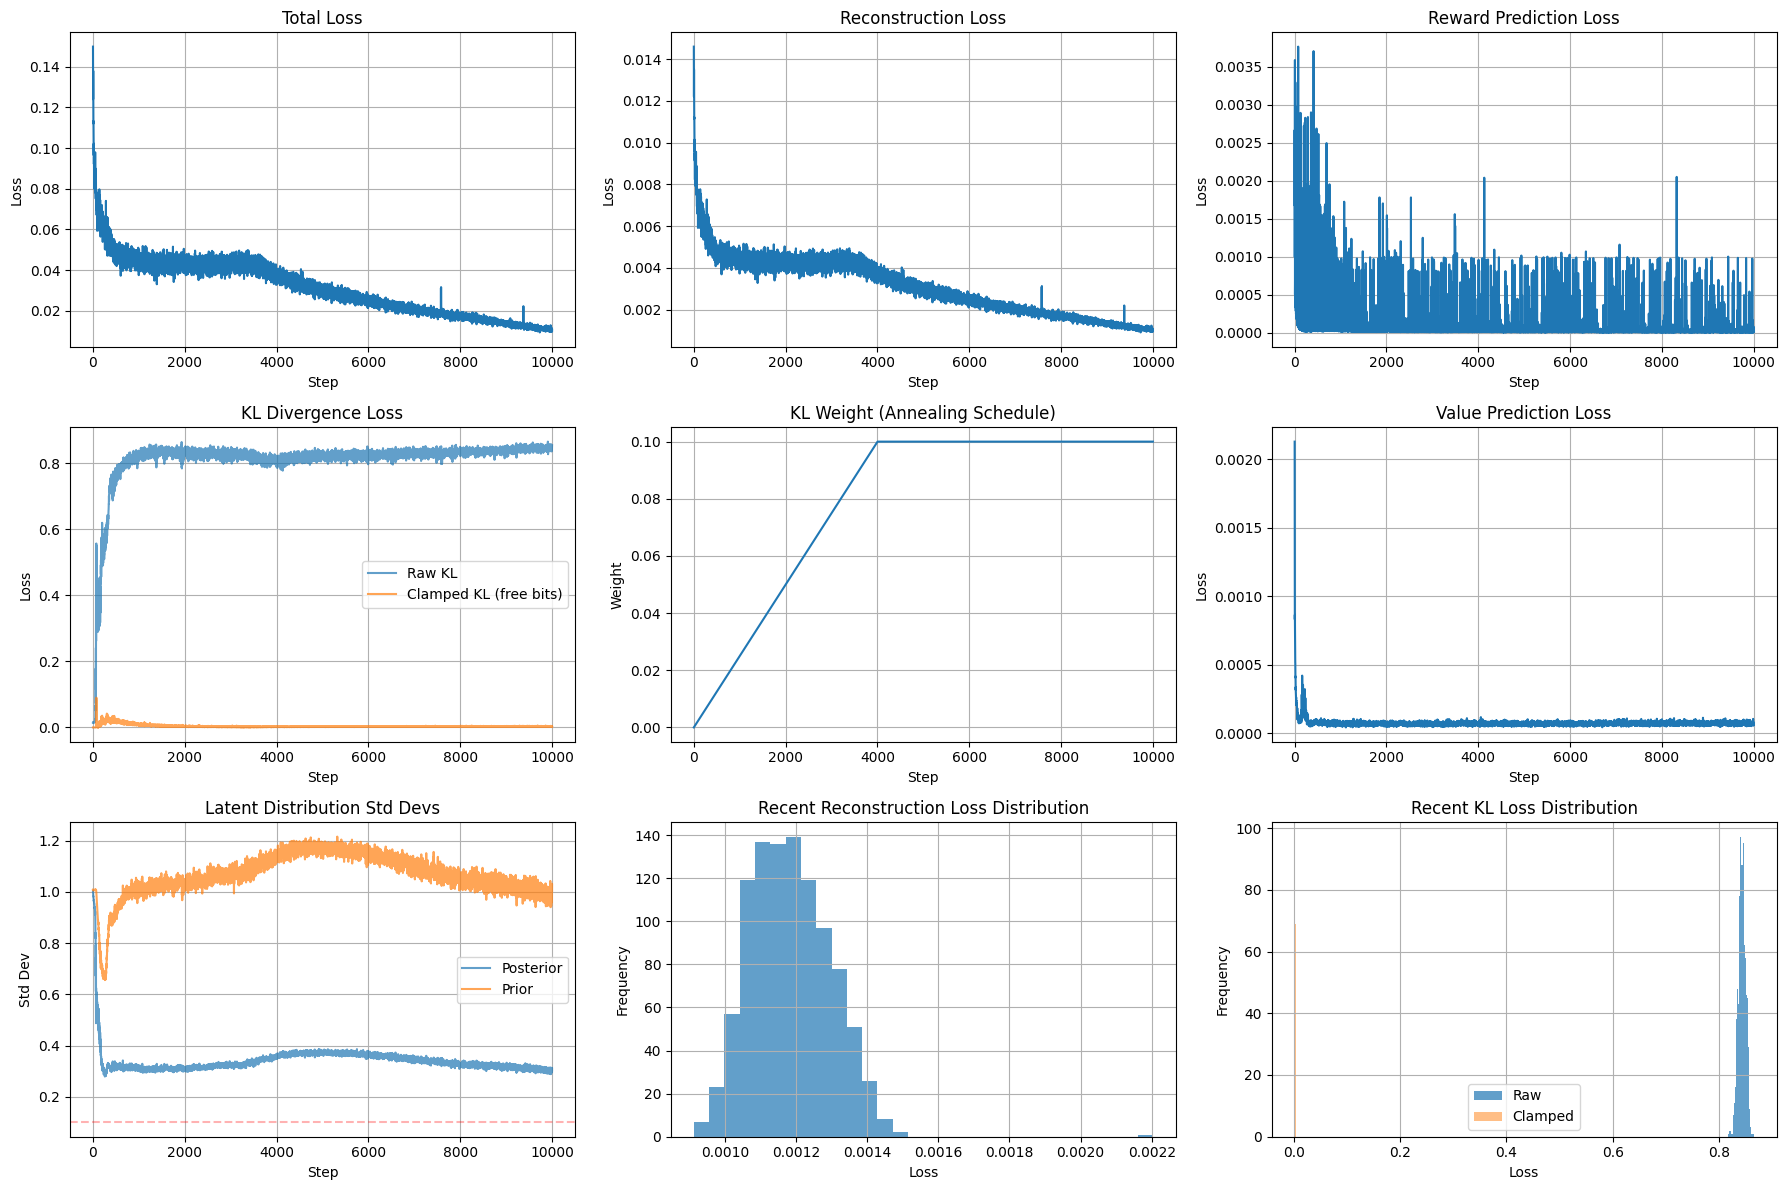


=== Training Summary ===
Final reconstruction loss: 0.001034
Final KL (raw/clamped): 0.853996 / 0.002705
Final posterior std: 0.303451
Final prior std: 1.003746

Posterior collapse check:
  ⚠️ MARGINAL: Posterior std is low but not collapsed


In [32]:
# Plot training losses with enhanced diagnostics
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Row 1: Main losses
axes[0, 0].plot(losses_history['total'])
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

axes[0, 1].plot(losses_history['recon'])
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

axes[0, 2].plot(losses_history['reward'])
axes[0, 2].set_title('Reward Prediction Loss')
axes[0, 2].set_xlabel('Step')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True)

# Row 2: KL diagnostics
axes[1, 0].plot(losses_history['kl_raw'], label='Raw KL', alpha=0.7)
axes[1, 0].plot(losses_history['kl'], label='Clamped KL (free bits)', alpha=0.7)
axes[1, 0].set_title('KL Divergence Loss')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(losses_history['kl_weight'])
axes[1, 1].set_title('KL Weight (Annealing Schedule)')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Weight')
axes[1, 1].grid(True)

axes[1, 2].plot(losses_history['value'])
axes[1, 2].set_title('Value Prediction Loss')
axes[1, 2].set_xlabel('Step')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].grid(True)

# Row 3: Posterior collapse diagnostics
axes[2, 0].plot(losses_history['posterior_std'], label='Posterior', alpha=0.7)
axes[2, 0].plot(losses_history['prior_std'], label='Prior', alpha=0.7)
axes[2, 0].set_title('Latent Distribution Std Devs')
axes[2, 0].set_xlabel('Step')
axes[2, 0].set_ylabel('Std Dev')
axes[2, 0].legend()
axes[2, 0].grid(True)
axes[2, 0].axhline(y=0.1, color='r', linestyle='--', alpha=0.3, label='Collapse threshold')

# Histogram of final losses
axes[2, 1].hist(losses_history['recon'][-1000:], bins=30, alpha=0.7)
axes[2, 1].set_title('Recent Reconstruction Loss Distribution')
axes[2, 1].set_xlabel('Loss')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].grid(True)

# Histogram of KL
axes[2, 2].hist(losses_history['kl_raw'][-1000:], bins=30, alpha=0.7, label='Raw')
axes[2, 2].hist(losses_history['kl'][-1000:], bins=30, alpha=0.5, label='Clamped')
axes[2, 2].set_title('Recent KL Loss Distribution')
axes[2, 2].set_xlabel('Loss')
axes[2, 2].set_ylabel('Frequency')
axes[2, 2].legend()
axes[2, 2].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Training Summary ===")
print(f"Final reconstruction loss: {losses_history['recon'][-1]:.6f}")
print(f"Final KL (raw/clamped): {losses_history['kl_raw'][-1]:.6f} / {losses_history['kl'][-1]:.6f}")
print(f"Final posterior std: {losses_history['posterior_std'][-1]:.6f}")
print(f"Final prior std: {losses_history['prior_std'][-1]:.6f}")
print(f"\nPosterior collapse check:")
if losses_history['posterior_std'][-1] < 0.1:
    print("  ⚠️ WARNING: Posterior may have collapsed (std < 0.1)")
elif losses_history['posterior_std'][-1] > 0.5:
    print("  ✅ GOOD: Posterior is active (std > 0.5)")
else:
    print("  ⚠️ MARGINAL: Posterior std is low but not collapsed")


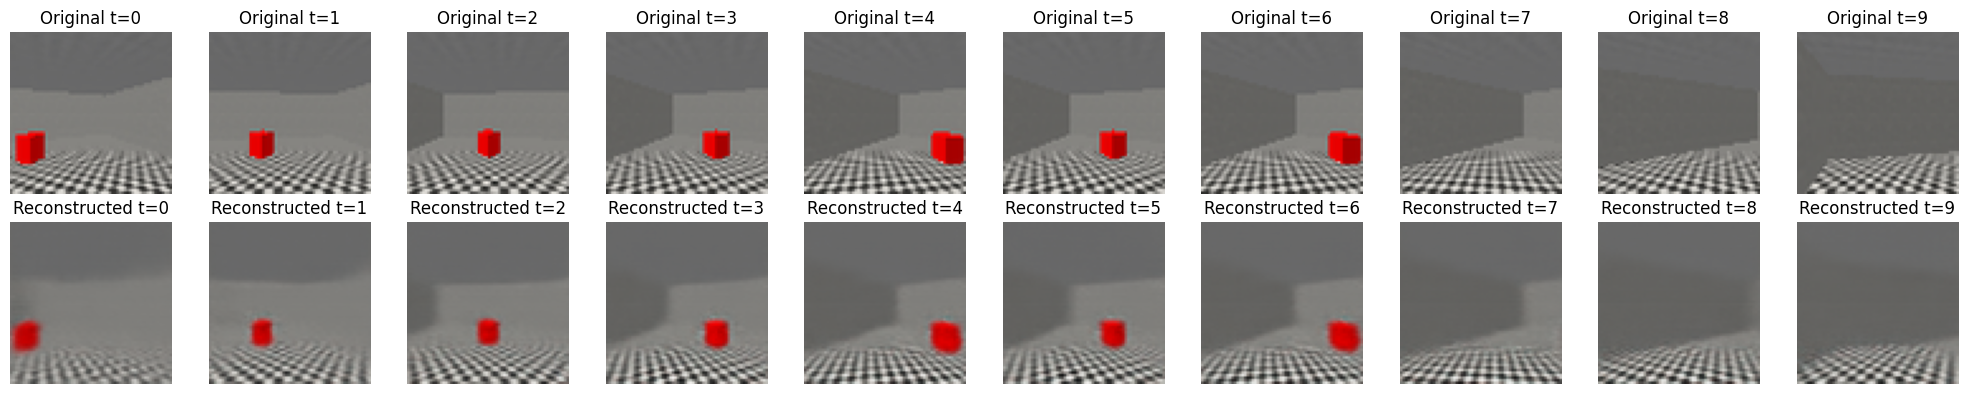


=== Reconstruction Statistics (t=0) ===
Original image:
  Mean: 0.4645, Std: 0.1200
  Min: 0.0000, Max: 1.0000

Reconstructed image:
  Mean: 0.4625, Std: 0.0810
  Min: 0.0013, Max: 0.8111

Per-channel (RGB) statistics:
  Red - Orig: 0.4857, Recon: 0.4791
  Green - Orig: 0.4579, Recon: 0.4581
  Blue - Orig: 0.4499, Recon: 0.4503

MSE: 0.008708
RMSE: 0.093314

✅ Reconstruction has variance: 0.0810

=== Latent / reward / value for visualized timesteps ===

t=0:
  r_hat: -0.0001, v_hat: 0.0062
  z_t norm: 7.7090
  z_t (first 8 dims): [ 0.50536823  2.0908837   0.38203716 -0.64469993  0.34885     0.21780579
  0.57420206 -1.1235796 ]

t=1:
  r_hat: 0.0022, v_hat: 0.0028
  z_t norm: 8.7303
  z_t (first 8 dims): [ 0.15992898 -0.13387613 -1.1460807   1.1799371  -0.65469885  0.47471142
  0.02551991 -0.52550286]

t=2:
  r_hat: 0.0010, v_hat: -0.0008
  z_t norm: 5.4316
  z_t (first 8 dims): [ 0.18939418 -0.03122157 -0.915651    0.31602365  0.19042608 -0.41438144
  0.15019047 -0.25490946]

t=3:
  r

In [33]:
# Visualize reconstructions with detailed statistics
model.eval()
with torch.no_grad():
    # Sample a sequence
    batch = replay_buffer.sample_sequences(batch_size=1, seq_length=10)
    if batch is not None:
        obs_seq, action_seq, reward_seq, done_seq = batch
        obs_seq = obs_seq.to(device)
        action_seq = action_seq.to(device)
        
        # Reconstruct and collect latents / predictions
        h_prev = None
        z_prev = None
        reconstructions = []
        latents_h = []
        latents_z = []
        rewards_hat = []
        values_hat = []
        
        for t in range(min(10, obs_seq.shape[1])):
            obs_t = obs_seq[:, t]
            if t == 0:
                action_prev = torch.zeros(1, config['action_dim'], device=device)
            else:
                action_prev = action_seq[:, t-1]
            
            outputs = model(obs_t, action_prev, h_prev, z_prev, use_posterior=True)
            reconstructions.append(outputs['o_hat_t'])
            latents_h.append(outputs['h_t'].detach().cpu())
            latents_z.append(outputs['z_t'].detach().cpu())
            rewards_hat.append(outputs['r_hat_t'].detach().cpu())
            values_hat.append(outputs['v_hat_t'].detach().cpu())
            h_prev = outputs['h_t']
            z_prev = outputs['z_t']
        
        # Plot original vs reconstructed
        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        for t in range(min(10, len(reconstructions))):
            # Original
            orig = obs_seq[0, t].cpu().numpy().transpose(1, 2, 0)
            axes[0, t].imshow(np.clip(orig, 0, 1))
            axes[0, t].set_title(f'Original t={t}')
            axes[0, t].axis('off')
            
            # Reconstructed
            recon = reconstructions[t][0].cpu().numpy().transpose(1, 2, 0)
            axes[1, t].imshow(np.clip(recon, 0, 1))
            axes[1, t].set_title(f'Reconstructed t={t}')
            axes[1, t].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics for the first frame
        print("\n=== Reconstruction Statistics (t=0) ===")
        orig_0 = obs_seq[0, 0].cpu().numpy()
        recon_0 = reconstructions[0][0].cpu().numpy()
        
        print(f"Original image:")
        print(f"  Mean: {orig_0.mean():.4f}, Std: {orig_0.std():.4f}")
        print(f"  Min: {orig_0.min():.4f}, Max: {orig_0.max():.4f}")
        
        print(f"\nReconstructed image:")
        print(f"  Mean: {recon_0.mean():.4f}, Std: {recon_0.std():.4f}")
        print(f"  Min: {recon_0.min():.4f}, Max: {recon_0.max():.4f}")
        
        # Per-channel statistics
        print(f"\nPer-channel (RGB) statistics:")
        for c, color in enumerate(['Red', 'Green', 'Blue']):
            print(f"  {color} - Orig: {orig_0[c].mean():.4f}, Recon: {recon_0[c].mean():.4f}")
        
        # MSE
        mse = np.mean((orig_0 - recon_0) ** 2)
        print(f"\nMSE: {mse:.6f}")
        print(f"RMSE: {np.sqrt(mse):.6f}")
        
        # Check if reconstruction is constant
        if recon_0.std() < 0.01:
            print("\n⚠️ WARNING: Reconstruction has very low variance - likely outputting constant values!")
            print(f"This suggests the decoder is not learning. Check:")
            print(f"  1. Is the reconstruction loss actually backpropagating?")
            print(f"  2. Is the KL loss too strong initially?")
            print(f"  3. Are the latent codes carrying information?")
        else:
            print(f"\n✅ Reconstruction has variance: {recon_0.std():.4f}")
        
        # Latent, reward, and value for the visualized timesteps
        print("\n=== Latent / reward / value for visualized timesteps ===")
        for t in range(len(reconstructions)):
            z_vec = latents_z[t][0].numpy()
            r_hat = rewards_hat[t][0].item()
            v_hat = values_hat[t][0].item()
            print(f"\nt={t}:")
            print(f"  r_hat: {r_hat:.4f}, v_hat: {v_hat:.4f}")
            print(f"  z_t norm: {np.linalg.norm(z_vec):.4f}")
            print(f"  z_t (first 8 dims): {z_vec[:8]}")


In [34]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': config,
    'losses_history': losses_history,
}, 'worldmodel_checkpoint.pth')
print("Model saved to worldmodel_checkpoint.pth")


Model saved to worldmodel_checkpoint.pth


## 5. Planning with MCTS in Latent Space

Now we use the learned world model as a simulator for MCTS.

### 5.1 Node representation
Each tree node stores:
- Latent state $(h, z)$
- Estimated value $v$
- Reward from parent → this node
- Prior policy distribution over actions $p(a|s)$
- Visit counts $N(s,a)$
- Value estimates $Q(s,a)$

### 5.2 MCTS algorithm (MuZero-style)
From the current real observation $o_t$:
1. **Encode**: $e_t = \text{Enc}(o_t)$, then use posterior update to get $(h_t, z_t)$ = root latent state.
2. **Run MCTS** for 50–200 simulations:
   - **SELECT**: Use PUCT to select actions down to a leaf
   - **EXPAND & EVALUATE**: Use RSSM prior to step in latent space, predict reward/value/policy
   - **BACKUP**: Propagate value estimates up the path
3. **Choose action** from visit-count distribution

In [35]:
# ============================================================================
# 5.3 Helper functions: Get root latent state from real observation
# ============================================================================

def get_root_state(model, obs, h_prev, z_prev, action_prev, device):
    """
    Compute the root latent state (h_t, z_t) for MCTS from a real observation.
    
    This uses the encoder + RSSM posterior (the "representation function" in MuZero terms).
    
    Args:
        model: WorldModel instance
        obs: (3, 64, 64) numpy array or tensor - current observation
        h_prev: (hidden_dim,) tensor - previous deterministic state (or None for t=0)
        z_prev: (stochastic_dim,) tensor - previous stochastic state (or None for t=0)
        action_prev: int - previous action taken (or None for t=0)
        device: torch device
    
    Returns:
        h_t: (hidden_dim,) tensor - current deterministic state
        z_t: (stochastic_dim,) tensor - current stochastic state (from posterior)
    """
    model.eval()
    
    with torch.no_grad():
        # Prepare observation
        if isinstance(obs, np.ndarray):
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)  # (1, 3, 64, 64)
        else:
            obs_tensor = obs.unsqueeze(0) if obs.dim() == 3 else obs
            obs_tensor = obs_tensor.to(device)
        
        # Initialize states if None (first timestep)
        if h_prev is None:
            h_prev = torch.zeros(model.hidden_dim, device=device)
        if z_prev is None:
            z_prev = torch.zeros(model.stochastic_dim, device=device)
        
        # Prepare previous action as one-hot
        if action_prev is None:
            action_one_hot = torch.zeros(1, model.action_dim, device=device)
        else:
            action_one_hot = F.one_hot(
                torch.tensor([action_prev], device=device), 
                num_classes=model.action_dim
            ).float()
        
        # Step 1: RSSM prior to get h_t (deterministic state update)
        h_t, _, _ = model.rssm.prior(
            h_prev.unsqueeze(0),  # (1, hidden_dim)
            z_prev.unsqueeze(0),  # (1, stochastic_dim)
            action_one_hot        # (1, action_dim)
        )
        h_t = h_t.squeeze(0)  # (hidden_dim,)
        
        # Step 2: Encode observation
        e_t = model.encoder(obs_tensor)  # (1, embedding_dim)
        
        # Step 3: RSSM posterior to get z_t (corrected stochastic state)
        z_t, _ = model.rssm.posterior(h_t.unsqueeze(0), e_t)
        z_t = z_t.squeeze(0)  # (stochastic_dim,)
    
    return h_t, z_t


def mcts_policy(model, obs, h_prev, z_prev, action_prev, device, 
                num_simulations=50, c_puct=1.0, discount=0.99, temperature=1.0):
    """
    Use MCTS to select an action given the current observation.
    
    Args:
        model: WorldModel instance
        obs: (3, 64, 64) numpy array - current observation
        h_prev: previous deterministic state (or None)
        z_prev: previous stochastic state (or None)
        action_prev: previous action (or None)
        device: torch device
        num_simulations: number of MCTS simulations
        c_puct: exploration constant
        discount: reward discount factor
        temperature: action selection temperature (0 = greedy, 1 = proportional)
    
    Returns:
        action: int - selected action
        policy_target: np.array - visit count distribution (for training)
        value: float - root value estimate
        h_t: tensor - current deterministic state (to pass to next step)
        z_t: tensor - current stochastic state (to pass to next step)
    """
    # Get root latent state from real observation
    h_t, z_t = get_root_state(model, obs, h_prev, z_prev, action_prev, device)
    
    # Run MCTS from this root state
    action, policy_target, value = MCTS(
        world_model=model,
        root_h=h_t,
        root_z=z_t,
        c_puct=c_puct,
        num_simulations=num_simulations,
        discount=discount,
        action_space_size=model.action_dim,
        temperature=temperature,
    )
    
    return action, policy_target, value, h_t, z_t


print("MCTS helper functions defined!")
print("  - get_root_state(): Encode observation → latent state")
print("  - mcts_policy(): Full MCTS planning from observation")


MCTS helper functions defined!
  - get_root_state(): Encode observation → latent state
  - mcts_policy(): Full MCTS planning from observation


In [36]:
# ============================================================================
# 5.4 Test MCTS planning on a single episode
# ============================================================================

def run_mcts_episode(env, model, device, max_steps=500, num_simulations=50, 
                     c_puct=1.0, discount=0.99, temperature=1.0, render=False):
    """
    Run a single episode using MCTS for action selection.
    
    Returns:
        trajectory: list of (obs, action, reward, next_obs, done, policy_target, value)
        total_reward: float
        episode_length: int
    """
    obs, info = env.reset()
    obs = preprocess_obs(obs)
    
    trajectory = []
    total_reward = 0
    
    # Initialize recurrent states
    h_prev = None
    z_prev = None
    action_prev = None
    
    for step in range(max_steps):
        # Use MCTS to select action
        action, policy_target, value, h_t, z_t = mcts_policy(
            model=model,
            obs=obs,
            h_prev=h_prev,
            z_prev=z_prev,
            action_prev=action_prev,
            device=device,
            num_simulations=num_simulations,
            c_puct=c_puct,
            discount=discount,
            temperature=temperature,
        )
        
        # Take step in environment
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = preprocess_obs(next_obs)
        done = terminated or truncated
        
        # Store transition with MCTS policy target
        trajectory.append({
            'obs': obs.copy(),
            'action': action,
            'reward': float(reward),
            'next_obs': next_obs.copy(),
            'done': float(done),
            'policy_target': policy_target.copy(),
            'value': value,
        })
        
        total_reward += reward
        
        # Update for next step
        obs = next_obs
        h_prev = h_t
        z_prev = z_t
        action_prev = action
        
        if done:
            break
    
    return trajectory, total_reward, len(trajectory)


# Quick test: run one episode with MCTS
print("Testing MCTS planning on a single episode...")
model.eval()

test_traj, test_reward, test_length = run_mcts_episode(
    env=env,
    model=model,
    device=device,
    max_steps=200,
    num_simulations=25,  # Fewer sims for quick test
    temperature=1.0,
)

print(f"\nMCTS Test Episode:")
print(f"  Total reward: {test_reward:.2f}")
print(f"  Episode length: {test_length}")
print(f"  Sample policy targets (first 5 steps):")
for i in range(min(5, len(test_traj))):
    print(f"    t={i}: action={test_traj[i]['action']}, policy={test_traj[i]['policy_target']}, value={test_traj[i]['value']:.4f}")


Testing MCTS planning on a single episode...

MCTS Test Episode:
  Total reward: 0.36
  Episode length: 180
  Sample policy targets (first 5 steps):
    t=0: action=0, policy=[0.2  0.16 0.64], value=0.0023
    t=1: action=2, policy=[0.32 0.44 0.24], value=0.0025
    t=2: action=0, policy=[0.12 0.4  0.48], value=-0.0046
    t=3: action=1, policy=[0.6  0.16 0.24], value=-0.0019
    t=4: action=2, policy=[0.12 0.56 0.32], value=-0.0010


## 6. Training Loop: World Model + MCTS Agent

Full MuZero-style training loop:

1. **Warm-up phase** (pure model learning):
   - Run random/heuristic policy for N episodes
   - Train world model offline until reconstructions look decent

2. **Planning phase**:
   - Use MCTS + world model to choose actions
   - Collect new trajectories with MCTS policy targets
   - Add to replay buffer
   - Periodically retrain world model on growing replay buffer
   - **New**: Train policy/value heads to match MCTS targets (distillation)


In [37]:
# ============================================================================
# 6.1 Enhanced Replay Buffer for MCTS trajectories
# ============================================================================

class MCTSReplayBuffer:
    """
    Replay buffer that also stores MCTS policy targets and value estimates.
    """
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def add(self, obs, action, reward, next_obs, done, policy_target=None, value_target=None):
        """Add a single transition with optional MCTS targets"""
        self.buffer.append({
            'obs': obs,
            'action': action,
            'reward': reward,
            'next_obs': next_obs,
            'done': done,
            'policy_target': policy_target,  # MCTS visit distribution
            'value_target': value_target,    # MCTS root value or n-step return
        })
    
    def add_trajectory(self, trajectory):
        """Add a full trajectory (list of dicts)"""
        for t in trajectory:
            self.add(
                obs=t['obs'],
                action=t['action'],
                reward=t['reward'],
                next_obs=t['next_obs'],
                done=t['done'],
                policy_target=t.get('policy_target'),
                value_target=t.get('value'),
            )
    
    def sample_sequences(self, batch_size, seq_length, action_dim):
        """
        Sample sequences of length seq_length.
        Returns sequences with MCTS targets if available.
        """
        if len(self.buffer) < seq_length:
            return None
        
        max_start = len(self.buffer) - seq_length
        starts = np.random.randint(0, max_start, size=batch_size)
        
        obs_seq = []
        action_seq = []
        reward_seq = []
        done_seq = []
        policy_target_seq = []
        value_target_seq = []
        has_mcts_targets = []
        
        for start in starts:
            seq = [self.buffer[start + i] for i in range(seq_length)]
            
            obs_seq.append([s['obs'] for s in seq])
            action_seq.append([s['action'] for s in seq])
            reward_seq.append([s['reward'] for s in seq])
            done_seq.append([s['done'] for s in seq])
            
            # MCTS targets (may be None for warm-up data)
            policy_targets = [s['policy_target'] for s in seq]
            value_targets = [s['value_target'] for s in seq]
            
            # Check if this sequence has MCTS targets
            has_targets = all(p is not None for p in policy_targets)
            has_mcts_targets.append(has_targets)
            
            if has_targets:
                policy_target_seq.append(policy_targets)
                value_target_seq.append(value_targets)
            else:
                # Placeholder - uniform policy, zero value
                policy_target_seq.append([np.ones(action_dim) / action_dim for _ in seq])
                value_target_seq.append([0.0 for _ in seq])
        
        # Convert to tensors
        obs_tensor = torch.stack([
            torch.stack([torch.tensor(o, dtype=torch.float32) for o in obs]) 
            for obs in obs_seq
        ])
        action_tensor = torch.stack([
            torch.stack([F.one_hot(torch.tensor(a, dtype=torch.long), action_dim).float() for a in action]) 
            for action in action_seq
        ])
        reward_tensor = torch.stack([torch.tensor(r, dtype=torch.float32) for r in reward_seq])
        done_tensor = torch.stack([torch.tensor(d, dtype=torch.float32) for d in done_seq])
        policy_target_tensor = torch.stack([
            torch.stack([torch.tensor(p, dtype=torch.float32) for p in policy]) 
            for policy in policy_target_seq
        ])
        value_target_tensor = torch.stack([torch.tensor(v, dtype=torch.float32) for v in value_target_seq])
        has_mcts_tensor = torch.tensor(has_mcts_targets, dtype=torch.bool)
        
        return {
            'obs': obs_tensor,
            'action': action_tensor,
            'reward': reward_tensor,
            'done': done_tensor,
            'policy_target': policy_target_tensor,
            'value_target': value_target_tensor,
            'has_mcts_targets': has_mcts_tensor,
        }
    
    def __len__(self):
        return len(self.buffer)


print("MCTSReplayBuffer defined!")


MCTSReplayBuffer defined!


In [38]:
# ============================================================================
# 6.2 MuZero-style Training Step (with policy distillation)
# ============================================================================

def muzero_training_step(model, optimizer, batch, device, config, step):
    """
    Single training step with MuZero-style losses:
    - Reconstruction loss
    - Reward prediction loss
    - KL divergence loss
    - Value prediction loss (using n-step returns OR MCTS value targets)
    - Policy distillation loss (match MCTS visit distribution)
    """
    model.train()
    
    obs_seq = batch['obs'].to(device)           # (B, T, 3, 64, 64)
    action_seq = batch['action'].to(device)     # (B, T, action_dim)
    reward_seq = batch['reward'].to(device)     # (B, T)
    done_seq = batch['done'].to(device)         # (B, T)
    policy_target = batch['policy_target'].to(device)  # (B, T, action_dim)
    value_target = batch['value_target'].to(device)    # (B, T)
    has_mcts = batch['has_mcts_targets']        # (B,) bool
    
    B, T = obs_seq.shape[:2]
    
    # KL annealing
    if step < config['kl_anneal_steps']:
        kl_weight = config['lambda_kl_start'] + \
            (config['lambda_kl_end'] - config['lambda_kl_start']) * (step / config['kl_anneal_steps'])
    else:
        kl_weight = config['lambda_kl_end']
    
    # Forward pass through sequence
    h_prev = None
    z_prev = None
    all_outputs = []
    
    for t in range(T):
        obs_t = obs_seq[:, t]
        action_prev = torch.zeros(B, config['action_dim'], device=device) if t == 0 else action_seq[:, t-1]
        
        outputs = model(obs_t, action_prev, h_prev, z_prev, use_posterior=True)
        all_outputs.append(outputs)
        
        h_prev = outputs['h_t']
        z_prev = outputs['z_t']
    
    # Stack outputs
    o_hat_seq = torch.stack([o['o_hat_t'] for o in all_outputs], dim=1)
    r_hat_seq = torch.stack([o['r_hat_t'] for o in all_outputs], dim=1)
    v_hat_seq = torch.stack([o['v_hat_t'] for o in all_outputs], dim=1)
    policy_logits_seq = torch.stack([o['policy_logits'] for o in all_outputs], dim=1)
    
    # ========== LOSSES ==========
    
    # 1. Reconstruction loss
    recon_loss = F.mse_loss(o_hat_seq, obs_seq)
    
    # 2. Reward prediction loss
    reward_loss = F.mse_loss(r_hat_seq, reward_seq)
    
    # 3. KL loss with free bits
    kl_loss = torch.tensor(0.0, device=device)
    for t in range(T):
        if all_outputs[t]['prior_dist'] is not None and all_outputs[t]['post_dist'] is not None:
            kl_per_dim = torch.distributions.kl.kl_divergence(
                all_outputs[t]['post_dist'],
                all_outputs[t]['prior_dist']
            )
            kl_per_dim_clamped = torch.clamp(kl_per_dim - config['free_nats'], min=0.0)
            kl_loss += kl_per_dim_clamped.mean()
    kl_loss = kl_loss / T
    
    # 4. Value loss - use n-step returns computed from rewards
    with torch.no_grad():
        n_step_returns = compute_n_step_returns(
            reward_seq, done_seq, v_hat_seq.detach(),
            gamma=config['gamma'], n_step=config['n_step']
        )
    value_loss = F.mse_loss(v_hat_seq, n_step_returns)
    
    # 5. Policy distillation loss (only for samples with MCTS targets)
    # Cross-entropy between model policy and MCTS visit distribution
    policy_loss = torch.tensor(0.0, device=device)
    if has_mcts.any():
        # Flatten for cross-entropy: (B*T, action_dim)
        policy_logits_flat = policy_logits_seq.view(-1, config['action_dim'])
        policy_target_flat = policy_target.view(-1, config['action_dim'])
        
        # Create mask for samples with MCTS targets
        mask = has_mcts.unsqueeze(1).expand(-1, T).reshape(-1).to(device)
        
        if mask.sum() > 0:
            # Cross-entropy loss: -sum(target * log_softmax(logits))
            log_probs = F.log_softmax(policy_logits_flat[mask], dim=-1)
            policy_loss = -(policy_target_flat[mask] * log_probs).sum(dim=-1).mean()
    
    # Total loss
    total_loss = (
        config['lambda_rec'] * recon_loss +
        kl_weight * kl_loss +
        config['lambda_reward'] * reward_loss +
        config['lambda_value'] * value_loss +
        config.get('lambda_policy', 1.0) * policy_loss
    )
    
    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return {
        'total_loss': total_loss.item(),
        'recon_loss': recon_loss.item(),
        'reward_loss': reward_loss.item(),
        'kl_loss': kl_loss.item(),
        'value_loss': value_loss.item(),
        'policy_loss': policy_loss.item() if isinstance(policy_loss, torch.Tensor) else policy_loss,
        'kl_weight': kl_weight,
    }


print("MuZero training step defined!")


MuZero training step defined!


In [39]:
# ============================================================================
# 6.3 Full MuZero-style Training Loop
# ============================================================================

# Configuration for MCTS training
mcts_config = config.copy()
mcts_config.update({
    # MCTS parameters
    'num_simulations': 100,
    'c_puct': 1.0,
    'temperature_start': 1.0,    # High temp early for exploration
    'temperature_end': 0.1,      # Low temp later for exploitation
    'temperature_decay_episodes': 200,
    
    # Training schedule
    'mcts_episodes': 200,         # Episodes to collect with MCTS
    'training_steps_per_episode': 100,
    'eval_every': 10,
    
    # Policy distillation weight
    'lambda_policy': 1.0,
})

print("MCTS Training Configuration:")
for k in ['num_simulations', 'c_puct', 'temperature_start', 'temperature_end', 
          'mcts_episodes', 'training_steps_per_episode', 'lambda_policy']:
    print(f"  {k}: {mcts_config[k]}")


MCTS Training Configuration:
  num_simulations: 100
  c_puct: 1.0
  temperature_start: 1.0
  temperature_end: 0.1
  mcts_episodes: 200
  training_steps_per_episode: 100
  lambda_policy: 1.0


In [40]:
# ============================================================================
# 6.4 Run MCTS Training Loop
# ============================================================================

# Initialize new replay buffer for MCTS data
mcts_replay_buffer = MCTSReplayBuffer(capacity=50000)

# Copy existing warm-up data (without MCTS targets)
print("Copying warm-up data to MCTS replay buffer...")
for item in replay_buffer.buffer:
    mcts_replay_buffer.add(
        obs=item['obs'],
        action=item['action'],
        reward=item['reward'],
        next_obs=item['next_obs'],
        done=item['done'],
        policy_target=None,  # No MCTS target for warm-up data
        value_target=None,
    )
print(f"Copied {len(mcts_replay_buffer)} transitions")

# Training history
mcts_training_history = {
    'episode_rewards': [],
    'episode_lengths': [],
    'total_loss': [],
    'recon_loss': [],
    'reward_loss': [],
    'kl_loss': [],
    'value_loss': [],
    'policy_loss': [],
}

# Reset optimizer (optional - can continue from previous)
optimizer = optim.Adam(model.parameters(), lr=mcts_config['learning_rate'])

print("\n" + "="*60)
print("Starting MCTS Training Loop")
print("="*60)

global_step = 0

for episode in tqdm(range(mcts_config['mcts_episodes']), desc="MCTS Episodes"):
    # Temperature annealing
    temp_progress = min(1.0, episode / mcts_config['temperature_decay_episodes'])
    temperature = mcts_config['temperature_start'] + \
        (mcts_config['temperature_end'] - mcts_config['temperature_start']) * temp_progress
    
    # ========== COLLECT EPISODE WITH MCTS ==========
    trajectory, total_reward, episode_length = run_mcts_episode(
        env=env,
        model=model,
        device=device,
        max_steps=500,
        num_simulations=mcts_config['num_simulations'],
        c_puct=mcts_config['c_puct'],
        discount=mcts_config['gamma'],
        temperature=temperature,
    )
    
    # Add to replay buffer
    mcts_replay_buffer.add_trajectory(trajectory)
    
    mcts_training_history['episode_rewards'].append(total_reward)
    mcts_training_history['episode_lengths'].append(episode_length)
    
    # ========== TRAINING STEPS ==========
    for _ in range(mcts_config['training_steps_per_episode']):
        batch = mcts_replay_buffer.sample_sequences(
            batch_size=mcts_config['batch_size'],
            seq_length=mcts_config['seq_length'],
            action_dim=mcts_config['action_dim'],
        )
        
        if batch is None:
            continue
        
        losses = muzero_training_step(
            model=model,
            optimizer=optimizer,
            batch=batch,
            device=device,
            config=mcts_config,
            step=global_step,
        )
        
        mcts_training_history['total_loss'].append(losses['total_loss'])
        mcts_training_history['recon_loss'].append(losses['recon_loss'])
        mcts_training_history['reward_loss'].append(losses['reward_loss'])
        mcts_training_history['kl_loss'].append(losses['kl_loss'])
        mcts_training_history['value_loss'].append(losses['value_loss'])
        mcts_training_history['policy_loss'].append(losses['policy_loss'])
        
        global_step += 1
    
    # ========== EVALUATION ==========
    if (episode + 1) % mcts_config['eval_every'] == 0:
        # Run evaluation episode (greedy, no exploration)
        model.eval()
        eval_traj, eval_reward, eval_length = run_mcts_episode(
            env=env,
            model=model,
            device=device,
            max_steps=500,
            num_simulations=mcts_config['num_simulations'],
            temperature=0.0,  # Greedy
        )
        
        recent_train_rewards = mcts_training_history['episode_rewards'][-mcts_config['eval_every']:]
        
        print(f"\n[Episode {episode + 1}]")
        print(f"  Train reward (last {mcts_config['eval_every']}): {np.mean(recent_train_rewards):.2f} ± {np.std(recent_train_rewards):.2f}")
        print(f"  Eval reward: {eval_reward:.2f} (length: {eval_length})")
        print(f"  Temperature: {temperature:.3f}")
        print(f"  Losses - Total: {losses['total_loss']:.4f}, Policy: {losses['policy_loss']:.4f}")
        print(f"  Buffer size: {len(mcts_replay_buffer)}")

print("\n" + "="*60)
print("MCTS Training Complete!")
print("="*60)


Copying warm-up data to MCTS replay buffer...
Copied 50000 transitions

Starting MCTS Training Loop


MCTS Episodes:   5%|▌         | 10/200 [23:44<9:53:25, 187.40s/it]


[Episode 10]
  Train reward (last 10): 0.16 ± 0.54
  Eval reward: 0.07 (length: 180)
  Temperature: 0.960
  Losses - Total: 0.7756, Policy: 0.7478
  Buffer size: 50000


MCTS Episodes:  10%|█         | 20/200 [41:11<5:37:06, 112.37s/it]


[Episode 20]
  Train reward (last 10): 0.55 ± 0.54
  Eval reward: 1.04 (length: 34)
  Temperature: 0.914
  Losses - Total: 0.7527, Policy: 0.7286
  Buffer size: 50000


MCTS Episodes:  15%|█▌        | 30/200 [1:01:14<5:55:22, 125.42s/it]


[Episode 30]
  Train reward (last 10): 0.09 ± 0.44
  Eval reward: -0.42 (length: 180)
  Temperature: 0.869
  Losses - Total: 0.8000, Policy: 0.7764
  Buffer size: 50000


MCTS Episodes:  16%|█▌        | 31/200 [1:03:17<5:45:01, 122.50s/it]


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# 6.5 Plot MCTS Training Results
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(mcts_training_history['episode_rewards'])
axes[0, 0].set_title('Episode Rewards (MCTS)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Episode lengths
axes[0, 1].plot(mcts_training_history['episode_lengths'])
axes[0, 1].set_title('Episode Lengths')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].grid(True)

# Total loss
axes[0, 2].plot(mcts_training_history['total_loss'])
axes[0, 2].set_title('Total Loss')
axes[0, 2].set_xlabel('Training Step')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True)

# Policy loss (distillation)
axes[1, 0].plot(mcts_training_history['policy_loss'])
axes[1, 0].set_title('Policy Distillation Loss')
axes[1, 0].set_xlabel('Training Step')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Value loss
axes[1, 1].plot(mcts_training_history['value_loss'])
axes[1, 1].set_title('Value Loss')
axes[1, 1].set_xlabel('Training Step')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True)

# Reconstruction loss
axes[1, 2].plot(mcts_training_history['recon_loss'])
axes[1, 2].set_title('Reconstruction Loss')
axes[1, 2].set_xlabel('Training Step')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== MCTS Training Summary ===")
print(f"Total episodes: {len(mcts_training_history['episode_rewards'])}")
print(f"Total training steps: {len(mcts_training_history['total_loss'])}")
print(f"\nReward statistics:")
print(f"  Mean: {np.mean(mcts_training_history['episode_rewards']):.2f}")
print(f"  Std: {np.std(mcts_training_history['episode_rewards']):.2f}")
print(f"  Max: {np.max(mcts_training_history['episode_rewards']):.2f}")
print(f"  Last 10 mean: {np.mean(mcts_training_history['episode_rewards'][-10:]):.2f}")


In [ ]:
# ============================================================================
# 6.6 Save MCTS-trained Model
# ============================================================================

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': mcts_config,
    'mcts_training_history': mcts_training_history,
    'losses_history': losses_history,  # Original warm-up training
}, 'worldmodel_mcts_checkpoint.pth')

print("MCTS-trained model saved to worldmodel_mcts_checkpoint.pth")


## 7. Evaluation: Compare MCTS vs Random Policy

Final evaluation comparing the MCTS-trained agent against a random baseline.


In [ ]:
# ============================================================================
# 7.1 Final Evaluation
# ============================================================================

def evaluate_policy(env, policy_fn, num_episodes=10, max_steps=500):
    """Evaluate a policy over multiple episodes."""
    rewards = []
    lengths = []
    
    for _ in range(num_episodes):
        obs, info = env.reset()
        obs = preprocess_obs(obs)
        total_reward = 0
        
        # For MCTS policy
        h_prev, z_prev, action_prev = None, None, None
        
        for step in range(max_steps):
            action = policy_fn(obs, h_prev, z_prev, action_prev)
            
            # Handle MCTS policy return values
            if isinstance(action, tuple):
                action, _, _, h_prev, z_prev = action
                action_prev = action
            
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_obs = preprocess_obs(next_obs)
            done = terminated or truncated
            
            total_reward += reward
            obs = next_obs
            
            if done:
                break
        
        rewards.append(total_reward)
        lengths.append(step + 1)
    
    return np.array(rewards), np.array(lengths)


# Define policies
def random_policy(obs, h_prev=None, z_prev=None, action_prev=None):
    return env.action_space.sample()

def mcts_greedy_policy(obs, h_prev=None, z_prev=None, action_prev=None):
    return mcts_policy(
        model=model,
        obs=obs,
        h_prev=h_prev,
        z_prev=z_prev,
        action_prev=action_prev,
        device=device,
        num_simulations=50,
        temperature=0.0,  # Greedy
    )


print("Evaluating policies...")
model.eval()

# Evaluate random policy
print("\nEvaluating Random Policy...")
random_rewards, random_lengths = evaluate_policy(env, random_policy, num_episodes=20)

# Evaluate MCTS policy
print("Evaluating MCTS Policy...")
mcts_rewards, mcts_lengths = evaluate_policy(env, mcts_greedy_policy, num_episodes=20)

# Results
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nRandom Policy:")
print(f"  Reward: {random_rewards.mean():.2f} ± {random_rewards.std():.2f}")
print(f"  Length: {random_lengths.mean():.1f} ± {random_lengths.std():.1f}")

print(f"\nMCTS Policy (greedy):")
print(f"  Reward: {mcts_rewards.mean():.2f} ± {mcts_rewards.std():.2f}")
print(f"  Length: {mcts_lengths.mean():.1f} ± {mcts_lengths.std():.1f}")

improvement = mcts_rewards.mean() - random_rewards.mean()
print(f"\nImprovement over random: {improvement:+.2f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rewards comparison
x = np.arange(2)
width = 0.35
axes[0].bar(x, [random_rewards.mean(), mcts_rewards.mean()], 
            yerr=[random_rewards.std(), mcts_rewards.std()], capsize=5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Random', 'MCTS'])
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Policy Comparison: Rewards')
axes[0].grid(True, axis='y')

# Episode lengths comparison
axes[1].bar(x, [random_lengths.mean(), mcts_lengths.mean()],
            yerr=[random_lengths.std(), mcts_lengths.std()], capsize=5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Random', 'MCTS'])
axes[1].set_ylabel('Episode Length')
axes[1].set_title('Policy Comparison: Episode Length')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()
